# Importing Libraries

In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
import json
from ast import literal_eval
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import seaborn as sns
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

# Import the Dataset

In [7]:
# Load the datasets
movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

# Data Preprocessing

In [8]:
# Parse the JSON columns
def parse_json(df, column):
    df[column] = df[column].apply(literal_eval)
    return df

movies = parse_json(movies, 'genres')
movies = parse_json(movies, 'keywords')
credits = parse_json(credits, 'cast')
credits = parse_json(credits, 'crew')

In [9]:
# Extract top 3 genres
def extract_top3_genres(x):
    if isinstance(x, list):
        names = [i['name'] for i in x[:3]]
        return names
    return []

movies['top3_genres'] = movies['genres'].apply(extract_top3_genres)

In [10]:
# Extract top 3 actors
def extract_top3_cast(x):
    if isinstance(x, list):
        names = [i['name'] for i in x[:3]]
        return names
    return []

credits['top3_cast'] = credits['cast'].apply(extract_top3_cast)

In [11]:
# Extract director
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

credits['director'] = credits['crew'].apply(get_director)

In [12]:
# Merge datasets
movies = movies.merge(credits[['movie_id', 'top3_cast', 'director']], left_on='id', right_on='movie_id', how='left')

# Building up Model

In [13]:
# Calculate weighted rating
C = movies['vote_average'].mean()
m = movies['vote_count'].quantile(0.90)

def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

movies['weighted_rating'] = movies.apply(weighted_rating, axis=1)

In [14]:
# Simple recommendation based on genre and language
def simple_recommendation(genre, language, top_n=5):
    df = movies[(movies['original_language'] == language) & (movies['top3_genres'].apply(lambda x: genre in x))]
    df = df.sort_values('weighted_rating', ascending=False)
    return df[['title', 'weighted_rating']].head(top_n)

In [16]:
# Content-based recommendation
def get_recommendations(title, cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices]

tfidf = TfidfVectorizer(stop_words='english')
movies['overview'] = movies['overview'].fillna('')
tfidf_matrix = tfidf.fit_transform(movies['overview'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

In [22]:
# Collaborative Filtering using Surprise
ratings = pd.read_csv('ratings_small.csv')
reader = Reader()
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

def collaborative_filtering(user_id, top_n=5):
    user_ratings = movies[movies['userId'] == user_id]
    user_ratings = user_ratings.merge(movies, on='movieId')
    return user_ratings[['title', 'rating']].head(top_n)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9003  0.8910  0.8935  0.8918  0.9045  0.8962  0.0053  
MAE (testset)     0.6938  0.6869  0.6896  0.6863  0.6953  0.6904  0.0036  
Fit time          3.33    3.32    3.23    3.39    3.42    3.34    0.06    
Test time         0.43    0.33    0.35    1.10    0.37    0.52    0.30    


In [18]:
# for Visualization
def plot_vote_distribution():
    plt.figure(figsize=(10, 6))
    sns.histplot(movies['vote_count'], bins=50, kde=True)
    plt.title('Vote Count Distribution')
    plt.xlabel('Vote Count')
    plt.ylabel('Frequency')
    plt.show()

def plot_top_voted_movies():
    top_voted = movies.sort_values('vote_count', ascending=False).head(20)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='vote_count', y='title', data=top_voted, palette='viridis')
    plt.title('Top 20 Movies by Vote Count')
    plt.xlabel('Vote Count')
    plt.ylabel('Movie Title')
    plt.show()

                                                  title  weighted_rating
65                                      The Dark Knight         7.920020
96                                            Inception         7.863239
329       The Lord of the Rings: The Return of the King         7.727243
1990                            The Empire Strikes Back         7.697884
262   The Lord of the Rings: The Fellowship of the Ring         7.667341
65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
Name: title, dtype: object


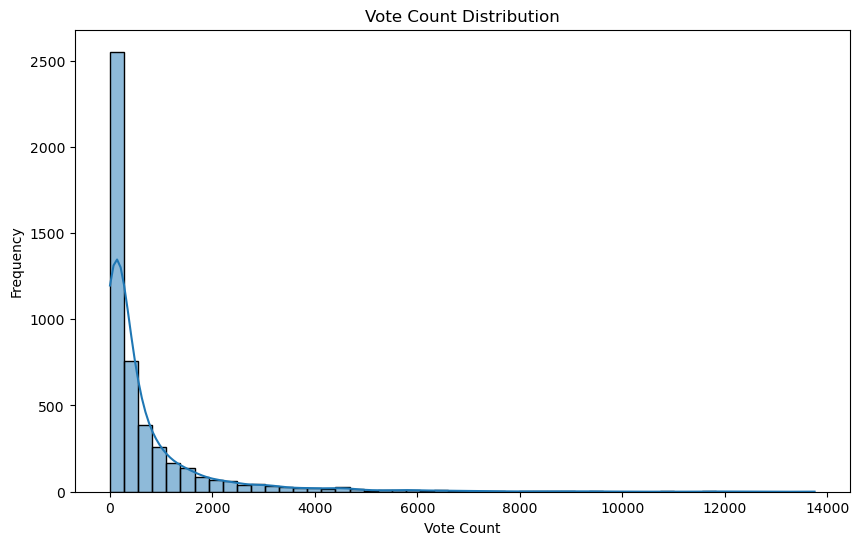

C:\Users\HP\AppData\Local\Temp\ipykernel_14036\3901316830.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='vote_count', y='title', data=top_voted, palette='viridis')


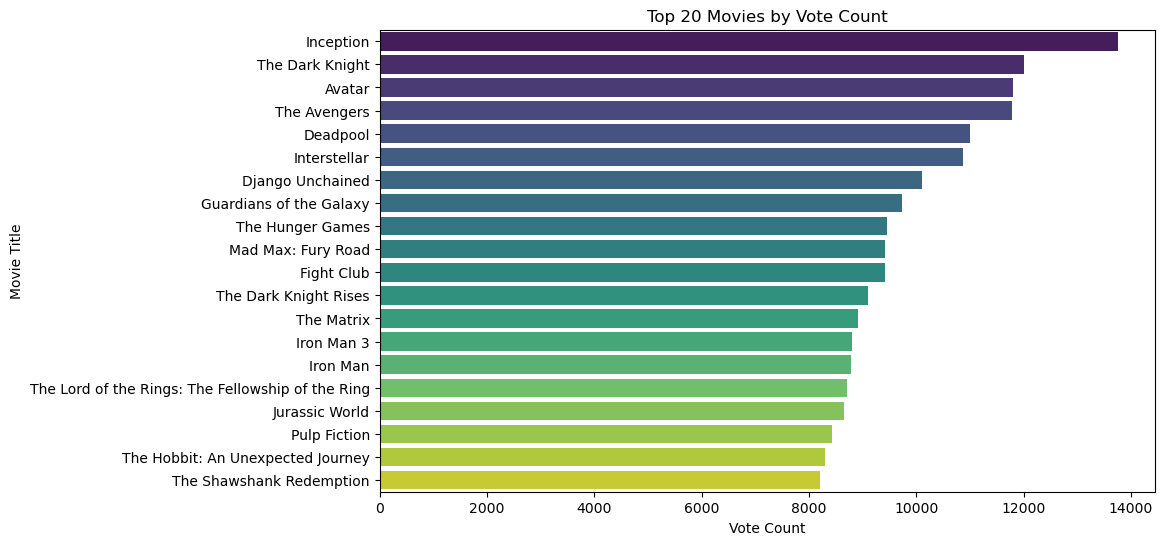

In [24]:
# Usage examples
print(simple_recommendation('Action', 'en'))
print(get_recommendations('The Dark Knight Rises', cosine_sim))
plot_vote_distribution()
plot_top_voted_movies()